In [1]:
from scipy.fft import fft
from scipy.linalg import expm
import time
import random
import json
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as ss
from scipy.optimize import minimize
from entforg import *
from IPython.display import display,Markdown,Latex

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.synthesis import MatrixExponential, LieTrotter
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from itertools import product
import math
from qiskit.primitives import Estimator
from qiskit.quantum_info.operators import Pauli
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper

from collections import defaultdict 
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from IPython.display import display
ME = MatrixExponential()

!!!!!!!!!!!!!!!!!!!!

Incluye la obtención de los términos diagonales cuadráticos (energías orbitales) teniendo en cuenta lo que aporten a estos el cambio de base de los cuadráticos, así como el uso del Estimator (ideal) para el cálculo de las energías, la creación del hamiltoniano problema a partir de los shifts y J dados, o la representación gráfica del espectro. También se guardan los valores de energías y matrices de rotación para todos los betas.

También se añaden las gráficas que usan como figura de mérito la suma de los errores en las energías.

!!!!!!!!!!!!!!!!!!!!

### Definimos las distintas funciones que nos permitirán llevar a cabo las optimizaciones.

In [2]:
# Estas son funciones para visualizar de una forma más agradable las matrices resultantes.
def MatrixToLatex(A):
    a="\\begin{bmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:           
                a=a+"{0:.2f}".format(A[i,j])
            else:
                a=a+"%s&"%"{0:.2f}".format(A[i,j])
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{bmatrix}"

    return(a)

def Display(string):
    display(Markdown(string))

    
def DisplayMatrix(A):
    A_Latex = MatrixToLatex(A)
    display(Markdown(A_Latex))

In [3]:
# Esta función calcula el hamiltoniano del problema, dados los valores de los shifts y el offset en ppm, de los J en Hz y de B en MHz. 
def Hspin(shifts, J, offset, B):
    # Leemos cuantos spines hay en el sistema.
    n=len(shifts)
    # Definimos los coeficientes que acompañarán a las cadenas de Pauli.
    w=[(shifts[i]-offset)*np.pi*B for i in range(n)]
    J2=[np.pi*J[i]/2 for i in range(len(J))]
    # Creamos las listas que guardarán los datos.
    pauli_strings = []
    coeffs=[]
    # Añadimos los términos correspondientes a los shifts.
    for i in range(n):
        string='I'*i+'Z'+'I'*(n-i-1)
        pauli_strings.append(string)
        coeffs.append(w[i])
    # Añadimos los términos correspondientes a los J.
    k=0
    for i in range(n):
        for j in range(n-i-1):
            strX='I'*i+'X'+'I'*j+'X'+'I'*(n-i-j-2)
            strY='I'*i+'Y'+'I'*j+'Y'+'I'*(n-i-j-2)
            strZ='I'*i+'Z'+'I'*j+'Z'+'I'*(n-i-j-2)
            pauli_strings.append(strX)
            coeffs.append(J2[k])
            pauli_strings.append(strY)
            coeffs.append(J2[k])
            pauli_strings.append(strZ)
            coeffs.append(J2[k])
            k+=1
    # Creamos y devolvemos el operador equivalente en la base de Pauli
    return SparsePauliOp.from_list(list(zip(pauli_strings, coeffs)))            

In [4]:
# Función necesaria para transformar los nombres de los elementos del diccionario que guarda la descomposición en operadores fermiónicos.
def transform_dict_keys(data):
    label_transformation = {
        "I": "",
        "N": "+_{} -_{}",
        "E": "-_{} +_{}",
        "+": "+_{}",
        "-": "-_{}",
    }

    new_data = {}
    for key, value in data.items():
        new_key_parts = []
        for i, char in enumerate(key):
            if char in label_transformation:
                # Apply transformation if the character is in the mapping
                transformed = label_transformation[char].format(i, i)
                if transformed:
                    new_key_parts.append(transformed)
        new_key = ' '.join(new_key_parts)  # Join the parts with spaces
        new_data[new_key] = value

    return new_data

# Función que transforma un operador descompuesto en cadenas de Pauli en un operador en la base fermiónica. 
# Aplica la transformación de Jordan-Wigner inversa.
def reverse_map(second_q_op: SparsePauliOp) -> FermionicOp:
        """Maps a class:`OperatorBase` to a `FermionicOp`.

        Args:
            second_q_op: the :class:`OperatorBase` to be mapped.

        Returns:
            The `FermionicOp` corresponding to the Hamiltonian in the Fermionic space.
        """

        num_qubits = second_q_op.num_qubits # get number of qubits from input second quantized operator
        fermionic_op = None
        for term in second_q_op:
            transform_list : List[Tuple(str, float)] = []  # list of tuple(pauli, coeff)
            coef_term = term.coeffs[0]  # Assuming coeffs is a list with a single element
            target_pauli_op = term.paulis[0]
            #print(target_pauli_op)

            for i in range(num_qubits):
                one_pauli = target_pauli_op[num_qubits - 1 - i]
                pauli_char=one_pauli.to_label()
                if pauli_char == 'Z': # dealing Pauli Z op
                    transform_list.append((('I',1),('N', -2))) # Zj -> I - 2*Nj => [('I', 1), ('N', -2)]
                elif pauli_char == 'X': # dealing Pauli X op
                    transform_list.append((("+", 1), ('-', 1))) # Xj -> aj_dag + aj => [('+', 1), ('-', 1)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                elif one_pauli.to_label() == 'Y': # dealing Pauli Y op
                    transform_list.append((('+', 1j), ('-', -1j))) # Yj -> i(aj - aj_dag) => [('+', -1j), ('-', 1j)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                else: 
                    # dealing Pauli I op
                    transform_list.append((('I', 0.5), ('I', 0.5))) # Ij -> Ij => [('I', 0.5), ('I', 0.5)]; split I into 0.5I + 0.5I for code consistency
            
            # dealing the phase
            if target_pauli_op.phase == 1:
                coef_term *= 1j
            elif target_pauli_op.phase == 2:
                coef_term *= -1
            elif target_pauli_op.phase == 3:
                coef_term *= -1j

            #print(transform_list)
            pauli_coefs = []
            pauli_strings = []
            # create fermionic operator for a term based on transform_list
            for idxes in product(*[[0, 1]]*num_qubits):
                pauli_coefs.append(math.prod([t[i][1] for t, i in zip(transform_list, idxes)]))
                pauli_strings.append("".join([t[i][0] for t, i in zip(transform_list, idxes)])[::-1])
            ferm_op=list(zip(pauli_strings, pauli_coefs))

            ferm_dict = defaultdict(float)

            # Iterate over each tuple in the list
            for key, value in ferm_op:
                # Sum the float values for tuples with the same string
                ferm_dict[key] += value

            ferm_dict_sparse=transform_dict_keys(ferm_dict)

            #print(ferm_dict)
            #print(ferm_dict_sparse)
            #print(coef_term)

            if not fermionic_op:
                fermionic_op = coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()
            else:
                fermionic_op += coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()

        return fermionic_op.simplify()

# Función que filtra los términos con dos operadores fermiónicos.
def filter_two_operator_terms(fermionic_op):
    """
    Filtra los términos con exactamente dos operadores del FermionicOp.

    Args:
        fermionic_op (FermionicOp): El operador fermiónico a filtrar.

    Returns:
        FermionicOp: Un nuevo FermionicOp con solo los términos de dos operadores.
    """
    filtered_data = {
        term: coeff
        for term, coeff in fermionic_op.items()
        if len(term.split()) == 2 or len(term.split())==0   # Solo términos con dos operadores
    }
    return FermionicOp(filtered_data, num_spin_orbitals=fermionic_op.num_spin_orbitals)

In [5]:
# Función que realiza el cambio de base del operador fermiónico, dada una matriz de cambio de base T.
def transform_fermionic_op(fermionic_op, T, T_conj):
    new_op_data = {}
    
    for term, coeff in fermionic_op.items():
        # Ignorar el término constante
        if term == '':
            new_op_data[''] = coeff
            continue
        
        # Expandir cada término en la nueva base
        new_terms = {}
        for t in term.split():
            op, idx = t[0], int(t[2])
            if op == '+':  # Transformación de operadores de creación
                new_operators = {f'+_{j}': T[j, idx] for j in range(len(T))}
            elif op == '-':  # Transformación de operadores de destrucción
                new_operators = {f'-_{j}': T_conj[j, idx] for j in range(len(T_conj))}
            
            # Combinar términos en la nueva base
            if not new_terms: # Si este término no existía, simplemente se guarda el nuevo.
                new_terms = new_operators
            else: # Si existía, se combinan los antiguos con los nuevos de esta iteración.
                new_terms = {
                    f"{k1} {k2}": v1 * v2
                    for k1, v1 in new_terms.items()
                    for k2, v2 in new_operators.items()
                }
        
        # Agregar al nuevo FermionicOp
        for new_term, new_coeff in new_terms.items():
            if new_term in new_op_data:
                new_op_data[new_term] += coeff * new_coeff
            else:
                new_op_data[new_term] = coeff * new_coeff

    return FermionicOp(new_op_data, num_spin_orbitals=len(T))


In [6]:
def filter_single_z_terms(sparse_pauli_op):
    """
    Filtra los términos en un SparsePauliOp que contienen exactamente una 'Z' y el resto son identidades ('I').

    Args:
        sparse_pauli_op (SparsePauliOp): El SparsePauliOp a filtrar.

    Returns:
         Dos SparsePauliOp: Un nuevo SparsePauliOp con los términos filtrados y otro con el resto de términos.
    """
    pauli_strings = sparse_pauli_op.paulis.to_labels()
    coeffs = sparse_pauli_op.coeffs

    # Filtrar términos con exactamente una 'Z' y el resto 'I'
    filtered_pauli_strings = []
    filtered_coeffs = []
    
    filtered_pauli_strings2 = []
    filtered_coeffs2 = []
    
    for pauli, coeff in zip(pauli_strings, coeffs):
        if pauli.count('Z') == 1 and pauli.count('I') == len(pauli) - 1:
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)
        elif pauli.count('I') == len(pauli):
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)
        else:
            filtered_pauli_strings2.append(pauli)
            filtered_coeffs2.append(coeff)

    # Crear y devolver el nuevo SparsePauliOp con los términos filtrados
    return SparsePauliOp.from_list(list(zip(filtered_pauli_strings, filtered_coeffs))), SparsePauliOp.from_list(list(zip(filtered_pauli_strings2, filtered_coeffs2)))

In [7]:
# Función que calcula el valor esperado de la energía del hamiltoniano total.
def expectation_classic(x, ansatz_U, beta, H_matrix, H_tot_matrix, shots, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    qclist=[]
    n=len(U_matrix)
    N_sites=int(np.log2(n))
    obs=SparsePauliOp.from_operator(Operator(H_matrix))
    for i in range(n):
        # Construimos el circuito
        qc=QuantumCircuit(N_sites)
        qc.initialize(i)
        qc=qc.compose(U_bound)
        # Añadimos a la lista el circuito con el observable.
        qclist.append([qc,obs])

    # Para calcular el valor esperado, necesitamos el Estimator.
    estimator = Estimator(options={"shots": shots})
    Energies=np.zeros(n)
    for i in range(n):
        job = estimator.run(qclist[i][0],qclist[i][1])
        # Las energías se corresponden con los valores del observable para cada circuito.
        Energies[i]=job.result().values[0]
    
    # Obtenemos el TFD a partir de estas energías y de la matriz U.
    TFD, _ = get_TFD(beta, U_matrix, np.conj(U_matrix), Energies)
    sTFD = ss.csr_matrix(TFD)
    # Obtenemos el valor esperado de la energía del hamiltoniano total en el estado dado por el TFD obtenido.
    total_energy = np.real(np.dot(np.conj(sTFD), np.dot(H_tot_matrix, sTFD.T)))[0,0]
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return total_energy
    
def callback(x):
    global x_arr
    x_arr.append(x)

# Función que calcula el valor de la energía libre.
def free_energy(x, ansatz_U, beta, H_matrix, H_tot_matrix, shots,cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    qclist=[]
    n=len(U_matrix)
    N_sites=int(np.log2(n))
    obs=SparsePauliOp.from_operator(Operator(H_matrix))
    for i in range(n):
        # Construimos el circuito
        qc=QuantumCircuit(N_sites)
        qc.initialize(i)
        qc=qc.compose(U_bound)
        # Añadimos a la lista el circuito con el observable.
        qclist.append([qc,obs])

    # Para calcular el valor esperado, necesitamos el Estimator.
    estimator = Estimator(options={"shots": shots})
    Energies=np.zeros(n)
    global job
    for i in range(n):
        job = estimator.run(qclist[i][0],qclist[i][1])
        # Las energías se corresponden con los valores del observable para cada circuito.
        Energies[i]=job.result().values[0]
    # Obtenemos el valor de la energía libre.
    energia_libre=-sum(np.exp(-beta*Energies))/beta
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return energia_libre

In [8]:
# Función que crea el circuito que usamos como ansatz.
def ansatz_U(qubit_op,N_sites, reps=2):
    ansatz_U = QuantumCircuit(N_sites) # Creamos nuestro circuito de N spines
    # Obtenemos los grupos de conmutación de nuestro operador de espines, así como los términos con un solo operador Z.
    group_cuadratic, terms_non_cuadratic=filter_single_z_terms(qubit_op)
    groups=terms_non_cuadratic.group_commuting()
    count = 0

    # Aplicamos tantas repeticiones como se nos diga del circuito. Primero, se aplican bloques correspondientes a todos los grupos de conmutación
    # y, después, se aplica un bloque extra correspondiente a los términos con un solo operador Z.
    for r in range(reps):
        for d in range(len(groups)):
            ansatz_U.append(PauliEvolutionGate(groups[len(groups)-d-1], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
            count += 1
        ansatz_U.append(PauliEvolutionGate(group_cuadratic, Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
    return ansatz_U

In [9]:
# Clases que nos permitirán representar el espectro, proporcionadas por Mestrelab.
class SpinSystem:
  def __init__(self):
    self.nucs = []
    self.jlist = []
    self.level =1
    
  def addNuc(self,name,shift):
      tn = nucleus(name,shift);
      self.nucs.append(tn)
      
  def addJ(self,name1,name2,j):
      tn = coupling(name1,name2,j);
      self.jlist.append(tn)
    
class nucleus:
    def __init__(self,name,shift):
      self.name = name
      self.shift = shift
      
class coupling:
    def __init__(self,name1,name2,j):
      self.name1 = name1
      self.name2=name2
      self.j = j
        
class NMRSimulator:
    E= np.matrix([[1, 0],[0, 1]])
    Ix = np.matrix([[0, 1/2],[1/2, 0]])
    Iy= np.matrix([[0, -1J/2], [1J/2, 0]])
    Iz = np.matrix([[1/2,0],[0,-1/2]])   
      
    def __init__(self):
      #std operators        
  

      # SET SIM parameters here
      self.field =400   
      self.swp = 10
      self.setOffsetPPM( 5)
      self.setTD(2**14)
      self.setT2(2);
      self.debug=False
      #self.noise=1/2000
      self.nucleus="1H"
      
    def setField(self,field):
        self.field=field
        self.offsetH = self.offset*self.field
        
    def setSWPPM(self,swp): 
        self.swp=swp
        self.swh=swp*self.field
        self.dw=1/self.swh
        
    def setOffsetPPM(self,offset):
        self.offset=offset
        self.offsetH = self.offset*self.field
        
    def setTD(self,td):
        self.td=int(td)
        
    def setT2(self, t2):
        self.t2=t2
      
    def getOperator (op, n):
        for i in range(n):
            if i==0:
                h=op
            else:
                h=NMRSimulator.E
            for j in range (1,n):
                if i==j:
                    h2=op
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            if(i==0):
                H=h
            else:
                H=H+h
        return H;
    
      
    def makeHamiltonian(self, ss):
        for n in ss.nucs:
            ind = ss.nucs.index(n)
            #print('nuc ' + n.name + ' ' +  str(ind))
            if ind==0:
                h=NMRSimulator.Iz
            else:
                h=NMRSimulator.E
            for i in range (1,len(ss.nucs)):
                if ind==i:
                    h2=NMRSimulator.Iz
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            h = h * np.pi*2 * (n.shift * self.field - self.offsetH)
            if(ind==0):
                H=h
            else:
                H=H+h
            
        #print('done nucs')
        for j in ss.jlist:
            ind1 = NMRSimulator.getIndexForName(j.name1, ss.nucs)
            ind2 = NMRSimulator.getIndexForName(j.name2, ss.nucs)
            #print (str(ind1) + '   ' + str(ind2))
            if ind1==0 or ind2==0:
                hx=NMRSimulator.Ix
                hy=NMRSimulator.Iy
                hz=NMRSimulator.Iz
                #print('ind0 hx')
            else:
                hx=NMRSimulator.E
                hy=NMRSimulator.E
                hz=NMRSimulator.E
                #print('ind0 E')
            for i in range (1,len(ss.nucs)):
                if ind1==i or ind2==i:
                    hx2=NMRSimulator.Ix
                    hy2=NMRSimulator.Iy
                    hz2=NMRSimulator.Iz
                    #print('indi hx')
                else:
                    hx2=NMRSimulator.E
                    hy2=NMRSimulator.E
                    hz2=NMRSimulator.E
                    #print('indi E')
                hx=np.kron(hx,hx2)
                hy=np.kron(hy,hy2)
                hz=np.kron(hz,hz2)
            H= H + 2*np.pi*j.j*(hx + hy + hz)
        return H

    def getIndexForName(name, nucs):
        for l in nucs:
            ind = nucs.index(l)
            if(l.name == name):
                return ind;
        

        
    def simSpinSystem(self, ss):
        H = self.makeHamiltonian(ss)
        m0 = NMRSimulator.getOperator(NMRSimulator.Ix,len(ss.nucs))
        IxT = m0
        IyT = NMRSimulator.getOperator(NMRSimulator.Iy,len(ss.nucs))
        vals,vecs = LA.eigh(H)
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)

        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi @ m0 @ vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm =  vecs @ expm(-1J * t[x] * diag) @ mMat @ expm(1J * t[x] * diag) @ vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm*IxT) * fac2)
            fidi[x] = np.real(np.trace(tm*IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
    def simSpinSystemQuantum(self, ss, vals, vecs, m_x, m_y):
    
        m0 = m_x
        IxT = m_x
        IyT = m_y
        
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)
        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi @ m0 @ vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm = vecs @ expm(-1J * t[x] * diag) @ mMat @ expm(1J * t[x] * diag) @ vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm @ IxT) * fac2)
            fidi[x] = np.real(np.trace(tm @ IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
#    def getNoise(self):
#        u = random.random(); 
#        v = random.random();
#        return math.sqrt(-2.0 * math.log(u)) * math.cos(2.0 * np.pi * v) * self.noise;
#    
#    def addNoise(self,re,im):
#        for i in range(len(re)):
#            re[i]=re[i]+self.getNoise()
#            im[i]=im[i]+self.getNoise()

    def simSpectrum(self, sss, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystem(ss)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] =np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs
    
    def simSpectrumQuantum(self, sss, vals, vecs, m_x, m_y, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystemQuantum(ss, vals, vecs, m_x, m_y)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] = np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs

In [10]:
# Funciones que nos permitirán crear la magnetizacion.
def local_spin_x(N_sites):
    ham=[]
    for i in range(0,N_sites):
        string='I'*i+'X'+'I'*(N_sites-1-i)
        ham.append(string)
    return ham

def local_spin_y(N_sites):
    ham=[]
    for i in range(0,N_sites):
        string='I'*i+'Y'+'I'*(N_sites-1-i)
        ham.append(string)
    return ham

In [11]:
# Función que transforma la magnetización según la matriz dada por la transformada de Bogoliubov.
def transform_M(T,Mx,My):
    T_conj=T
    # Transformamos la matrix dada a operadores fermiónicos mediante una Jordan-Wigner inversa.
    mag_fx=reverse_map(Mx)
    mag_fy=reverse_map(My)
    
    mag_new_x=transform_fermionic_op(mag_fx,T,T_conj)
    mag_new_y=transform_fermionic_op(mag_fy,T,T_conj)
    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    mag_mom_x=JW.map(mag_new_x.simplify()).chop(1e-6)
    mag_mom_y=JW.map(mag_new_y.simplify()).chop(1e-6)
    return mag_mom_x,mag_mom_y#, mag_fy

In [12]:
# Definimos la función que representa el espectro obtenido frente al teórico.
def reprSpectrum(shifts,J,d,SW,B,offset,energ,U,T,xlim=None,ylim=None,reprteo=True):
    # Construimos el SpinSystem asociado, añadiendo los shifts primero y los acoplamientos J después.
    sscase = SpinSystem()
    n=len(shifts)
    for i in range(n):
        sscase.addNuc(str(i), shifts[i])
    k=0
    for i in range(n):
        for j in range(i+1,n):
            sscase.addJ(str(i), str(j), J[k])
            k+=1
    sscase.level=1

    # Construimos las matrices de las magnetizaciones
    m_x=SparsePauliOp(local_spin_x(n),coeffs=0.5)
    m_y=SparsePauliOp(local_spin_y(n),coeffs=0.5)

    # Transformamos las matrices a la base correspondiente.
    mag_x, mag_y=transform_M(T,m_x,m_y)
    
    # Construimos el simulador NMR
    nmrsim = NMRSimulator()
    nmrsim.setField(B)
    nmrsim.setTD(d) # Resolución del espectro
    nmrsim.setSWPPM(SW) # Ancho espectral
    nmrsim.setOffsetPPM(offset)
    nmrsim.setT2(2.0)
    sss = []
    sss.append(sscase)
    # Calculamos el espectro a partir de las energías y la matriz U dadas
    spcOut, fs, v, w = nmrsim.simSpectrumQuantum(sss, energ, U, mag_x.to_matrix(),mag_y.to_matrix())
    # Calculamos el espectro teórico
    spcOutteo, fsteo, v, w= nmrsim.simSpectrum(sss)
    # Representamos ambos espectros para comparar.
    if reprteo:
        plt.plot(fsteo, spcOutteo,'-', label='Theoretical Spectrum', color='red',lw=2)
    plt.plot(fs, spcOut, '-', label='Experimental Spectrum', color='black',alpha=0.8)
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.legend()
    plt.show()

In [13]:
# Función que realiza la minimización para un hamiltoniano dado (en base de espines) y unos valores de beta. 
# La función que se minimiza puede escogerse con el argumento function.
def minimize_function(H, function, betas,shots=1024):
    # Medimos el tiempo que tarada la optimización.
    start=time.time()
    # Obtenemos el número de espines correspondiente al hamiltoniano dado.
    N_sites=H.num_qubits
    # Transformamos la descomposición obtenida a operadores fermiónicos mediante una Jordan-Wigner inversa.
    fermionic_op= reverse_map(H)


    # Creamos la matriz que guardará los coeficientes de la parte cuadrática del operador fermiónico. 
    num_spin_orbitals = fermionic_op.num_spin_orbitals
    h1 = np.zeros((num_spin_orbitals, num_spin_orbitals), dtype=np.complex128)
    
    # Extraemos términos cuadráticos.
    for term, coeff in fermionic_op.items():
        if term.count('+') == 1 and term.count('-') == 1:  # Verifica que tenga un operador de creación y uno de destrucción
            # Extraer los índices y los signos de los operadores
            indices = [int(t[2]) for t in term.split()]
            signs = [t[0] for t in term.split()]
            
            # Determinar las posiciones en la matriz según los signos
            if signs == ['+', '-']:  # Caso +_i -_j
                h1[indices[0], indices[1]] += coeff
            elif signs == ['-', '+']:  # Caso -_i +_j
                h1[indices[1], indices[0]] -= coeff  # Cambiar el signo del coeficiente

    # Obtenemos la matriz de cambio de base a una en la que la parte cuadrática sea diagonal mediante la transformación de Bogoliubov.
    # También obtenemos los valores diagonales, las energías orbitales.
    hamiltonian = QuadraticHamiltonian(
        hermitian_part=h1,
        constant=0)
    (transformation_matrix,
        orbital_energies,
        transformed_constant,
    ) = hamiltonian.diagonalizing_bogoliubov_transform()
    
    # Definimos la matriz de transformación
    T =transformation_matrix
    # Obtener la matriz conjugada transpuesta para transformar operadores de destrucción
    T_conj=T
    # T_conj = np.array(np.matrix(transformation_matrix).getH())
    # Transformamos el FermionicOp a la nueva base.
    fermionic_op_new = transform_fermionic_op(fermionic_op, T, T_conj)

    # Obtenemos los términos diagonales cuadráticos teniendo en cuenta lo que aporten a estos el cambio de base de los cuadráticos
    orbital_energies=np.array([np.real(fermionic_op_new['+_'+str(i)+' '+'-_'+str(i)]) for i in range(N_sites)])
    
    # Dividimos por un factor las energías orbitales para evitar problemas numéricos.
    factor=1000
    omega=orbital_energies/factor

    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    qubit_op=JW.map(fermionic_op_new.simplify()).chop(1e-6)
    # Construimos el ansatz a partir de este operador.
    ansatz=ansatz_U(qubit_op,N_sites)
    gate_number = ansatz.num_parameters

    # Obtenemos los valores teóricos de energías y autovectores asociados para comparar posteriormente los resultados obtenidos.
    H_q=qubit_op/factor
    H_matrix = H_q.to_matrix()
    E_L, U_L = np.linalg.eigh(H_matrix)
    
    # Creamos los hamiltonianos H_L y H_R
    identity = SparsePauliOp.from_list([('I'*N_sites, 1)])
    H_L = H_q^identity                 # H_L = H \otimes I
    H_R = (identity^H_q).conjugate()   # H_R = I \otimes H*

    # Creamos un vector en el que vamos a guardar los valores de los overlaps y del número de iteraciones realizadas para cada valor de beta.
    overlaps_TFD = np.zeros(len(betas))
    niter=np.zeros(len(betas))
    # Tambiéncreamos listas donde vamos a guardar los valores de las energías así como la matriz de rotación obtenidas para cada beta.
    energ=[]
    U=[]
    # Realizamos la minimización para cada valor de beta dado.
    for i, beta in enumerate(betas):
        # Creamos el hamiltoniano de interacción
        H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))
        
        # Creamos el hamiltoniano total
        H_tot = H_L + H_R + H_int_q
        H_tot_matrix = H_tot.to_matrix(sparse=True)
        H_tot_matrix.eliminate_zeros()
    
        # Calculamos el TFD teórico
        TFD_exact = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]
        
        x0 = 10**-1*np.random.random(gate_number)

        # Realizamos la minimización de la función elegida como parámetro.
        min_result = minimize(function, x0=x0, args=(ansatz, beta, H_matrix, H_tot_matrix,shots), tol=1e-10)

        # Calculamos la matriz asociada al circuito unitario para los parámetros obtenidos de la minimización.
        U_bound = ansatz.assign_parameters(min_result.x)
        U_matrix = Operator(U_bound).data
        U.append(U_matrix)
        
        # Calculamos las energías para esa matriz y obtenemos el TFD resultado de la optimización.
        # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
        qclist=[]
        n=len(U_matrix)
        N_sites=int(np.log2(n))
        obs=SparsePauliOp.from_operator(Operator(H_matrix))
        for j in range(n):
            # Construimos el circuito
            qc=QuantumCircuit(N_sites)
            qc.initialize(j)
            qc=qc.compose(U_bound)
            # Añadimos a la lista el circuito con el observable.
            qclist.append([qc,obs])
    
        # Para calcular el valor esperado, necesitamos el Estimator.
        estimator = Estimator(options={"shots": shots})
        Energies=np.zeros(n)
        for j in range(n):
            job = estimator.run(qclist[j][0],qclist[j][1])
            # Las energías se corresponden con los valores del observable para cada circuito.
            Energies[j]=job.result().values[0]
        energ.append(Energies)
        
        TFD_opt = get_TFD(beta, Operator(U_bound).data, np.conj(Operator(U_bound).data), Energies)[0]
        # Calculamos el overlap entre ambos TFD como el módulo del producto escalar de estos.
        overlaps_TFD[i] = np.abs(np.dot(np.conj(TFD_exact), TFD_opt))
        # Guardamos el número final de iteraciones realizadas.
        niter[i]=min_result.nit
    end=time.time()
    return overlaps_TFD, energ, U, niter, end-start, T

In [14]:
factor=1000

### Sulfanol

In [21]:
betas =[0.5]
shotslist=[2**10]

In [22]:
# Construimos H para el Sulfanol.
offset=5
B=400
shifts=[3.44,7.40]
J=[2.32]
matrizSulfanol=Hspin(shifts,J,offset,B)

In [23]:
results_expect=[]
energies_expect=[]
UExpect=[]
niterExpect=[]
tExpect=[]
TExp=[]
results_free_energy=[]
energies_free_energy=[]
UFE=[]
niterFE=[]
tFE=[]
TFE=[]
for shots in shotslist:
    # results_expecti, energies_expecti, UExpecti, niterExpecti, tExpecti, TExpi=minimize_function(matrizSulfanol,expectation_classic,betas,shots=shots)
    results_free_energyi, energies_free_energyi, UFEi, niterFEi, tFEi, TFEi=minimize_function(matrizSulfanol,free_energy,betas,shots=shots)
    results_expect.append(results_expecti)
    energies_expect.append(energies_expecti)
    UExpect.append(UExpecti)
    niterExpect.append(niterExpecti)
    tExpect.append(tExpecti)
    TExp.append(TExpi)
    results_free_energy.append(results_free_energyi)
    energies_free_energy.append(energies_free_energyi)
    UFE.append(UFEi)
    niterFE.append(niterFEi)
    tFE.append(tFEi)
    TFE.append(TFEi)

NameError: name 'results_expecti' is not defined

In [25]:
job.result()

EstimatorResult(values=array([-1.05193088]), metadata=[{'variance': 0, 'shots': 1024}])

In [ ]:
for i in range(len(shotslist)):
    plt.plot(betas, results_expect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

In [ ]:
for i in range(len(shotslist)):
    plt.plot(betas, results_free_energy[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

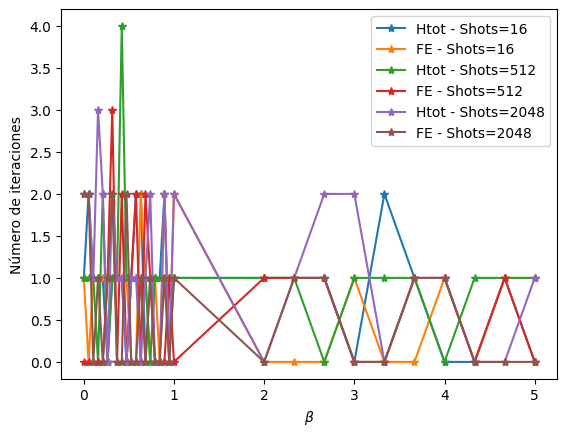

In [21]:
for i in range(len(shotslist)):
    plt.plot(betas, niterExpect[i], '*-', label='Htot - Shots='+str(shotslist[i]))
    plt.plot(betas, niterFE[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

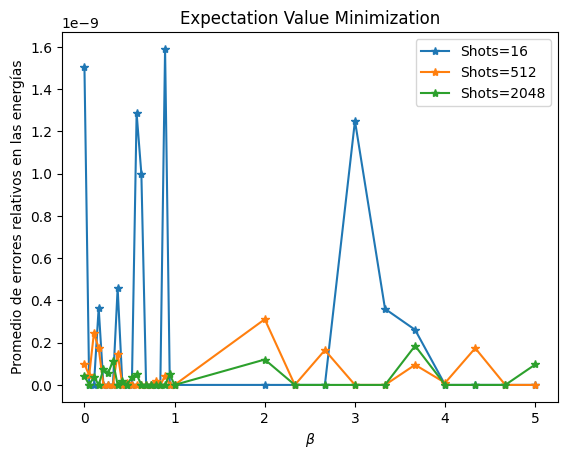

In [22]:
Eteo=np.sort(np.linalg.eig(matrizSulfanol.to_matrix())[0])
Eexpect=[[np.sort(energies_expect[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
Efreeenerg=[[np.sort(energies_free_energy[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
relerrorExpect=[[1/(len(Eteo))*sum([abs((Eexpect[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
relerrorFE=[[1/(len(Eteo))*sum([abs((Efreeenerg[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
for i in range(len(shotslist)):
    plt.plot(betas, relerrorExpect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

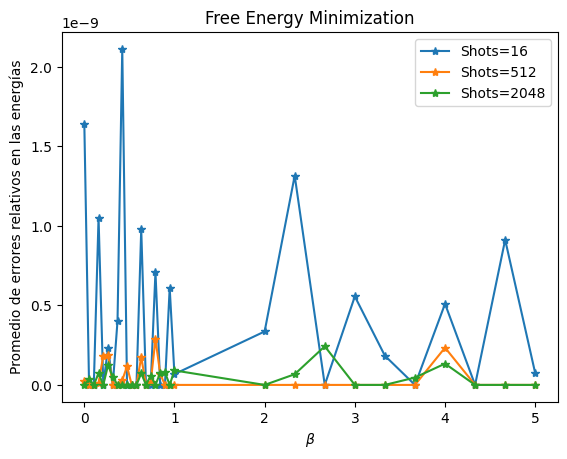

In [23]:
for i in range(len(shotslist)):
    plt.plot(betas, relerrorFE[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [24]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[0])*factor

array([[-4979.93231833, -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.6438606 ],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.93235514, -1051.93088413,  1059.21937908,  4972.64385562],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.93237392, -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.93236821, -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937

In [25]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[0])*factor

array([[-4979.93232924, -1051.93088413,  1059.21937908,  4972.64386699],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.93236925, -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.93235297, -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64386136],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.6438113 ],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334],
       [-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64387283],
       [-4979.9323483 , -1051.93088413,  1059.21937

In [26]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizSulfanol.to_matrix())[0])

array([-4979.9323483 +0.j, -1051.93088413+0.j,  1059.21937908+0.j,
        4972.64385334+0.j])

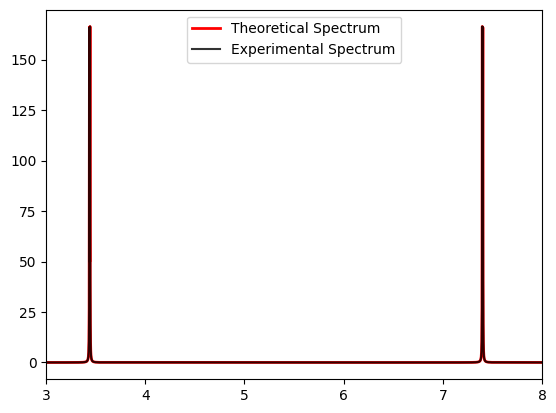

In [27]:
SW=10
d=10**5
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[0][-1]*factor,UFE[0][-1],TFE[0],xlim=[3,8])

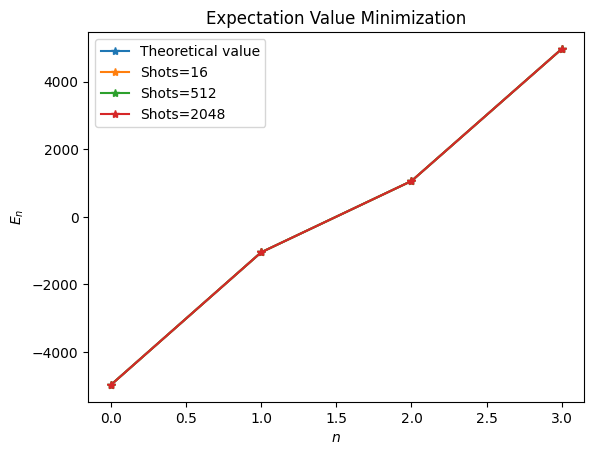

In [28]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

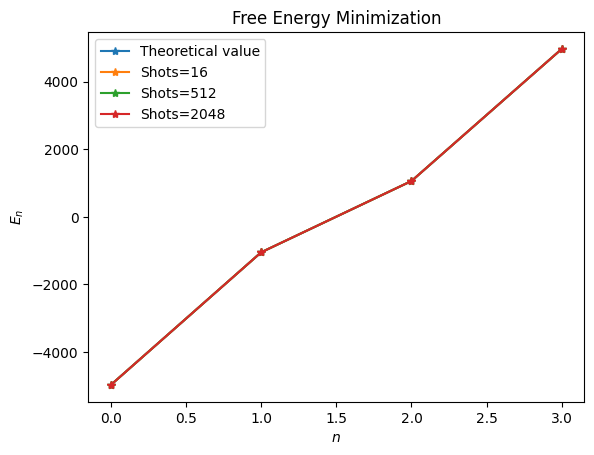

In [29]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Efreeenerg[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

### AB system

In [30]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))
shotslist=[2**4,2**9,2**11]

In [31]:
# Construimos H para el sistema AB.
offset=5
B=400
shifts=[1,1.025]
J=[10]
matrizAB=Hspin(shifts,J,offset,B)

In [32]:
results_expect=[]
energies_expect=[]
UExpect=[]
niterExpect=[]
tExpect=[]
TExp=[]
results_free_energy=[]
energies_free_energy=[]
UFE=[]
niterFE=[]
tFE=[]
TFE=[]
for shots in shotslist:
    results_expecti, energies_expecti, UExpecti, niterExpecti, tExpecti, TExpi=minimize_function(matrizAB,expectation_classic,betas,shots=shots)
    results_free_energyi, energies_free_energyi, UFEi, niterFEi, tFEi, TFEi=minimize_function(matrizAB,free_energy,betas,shots=shots)
    results_expect.append(results_expecti)
    energies_expect.append(energies_expecti)
    UExpect.append(UExpecti)
    niterExpect.append(niterExpecti)
    tExpect.append(tExpecti)
    TExp.append(TExpi)
    results_free_energy.append(results_free_energyi)
    energies_free_energy.append(energies_free_energyi)
    UFE.append(UFEi)
    niterFE.append(niterFEi)
    tFE.append(tFEi)
    TFE.append(TFEi)

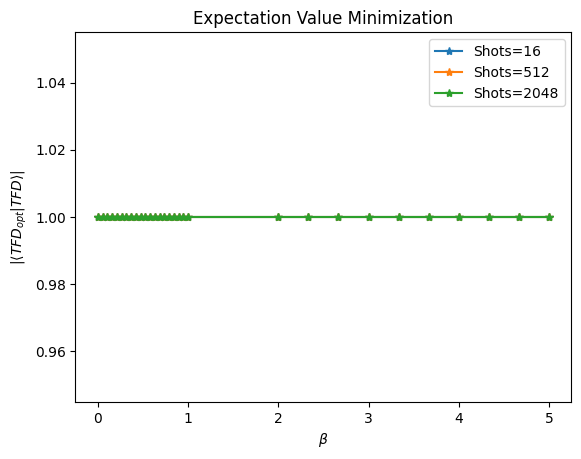

In [33]:
for i in range(len(shotslist)):
    plt.plot(betas, results_expect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

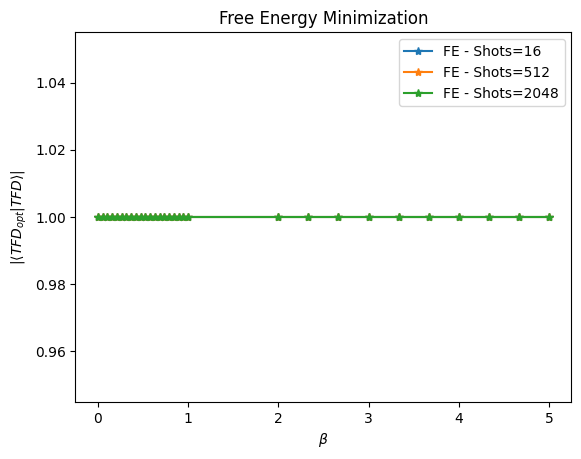

In [34]:
for i in range(len(shotslist)):
    plt.plot(betas, results_free_energy[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

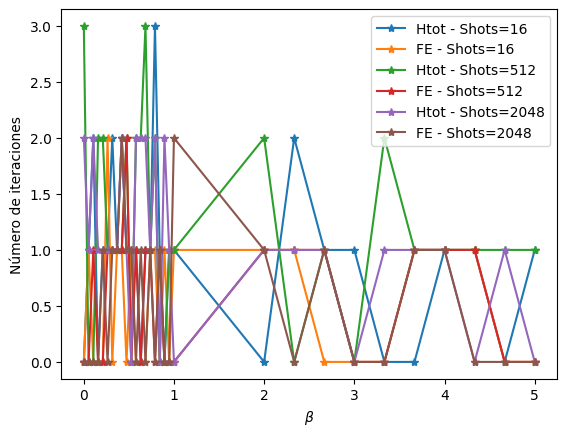

In [35]:
for i in range(len(shotslist)):
    plt.plot(betas, niterExpect[i], '*-', label='Htot - Shots='+str(shotslist[i]))
    plt.plot(betas, niterFE[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

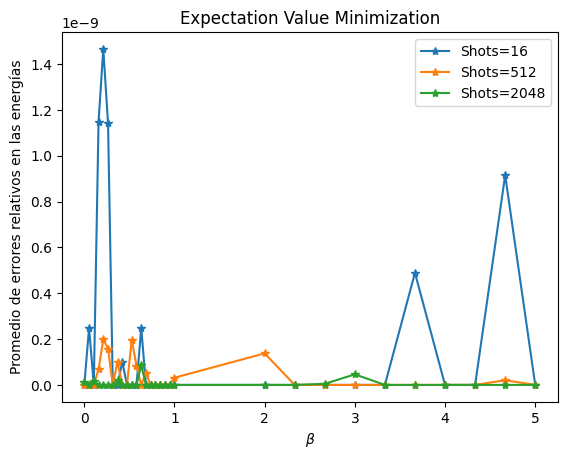

In [36]:
Eteo=np.sort(np.linalg.eig(matrizAB.to_matrix())[0])
Eexpect=[[np.sort(energies_expect[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
Efreeenerg=[[np.sort(energies_free_energy[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
relerrorExpect=[[1/(len(Eteo))*sum([abs((Eexpect[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
relerrorFE=[[1/(len(Eteo))*sum([abs((Efreeenerg[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
for i in range(len(shotslist)):
    plt.plot(betas, relerrorExpect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

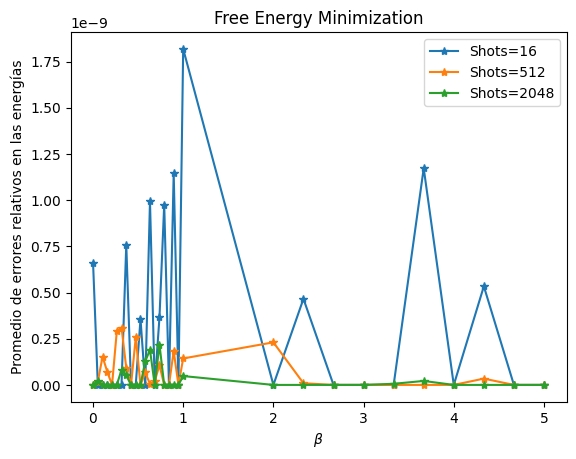

In [37]:
for i in range(len(shotslist)):
    plt.plot(betas, relerrorFE[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [38]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([[-10005.97260123,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260094,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260247,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
      

In [39]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([[-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260085,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260495,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97259962,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97260168,    -60.13679265,     28.72086611,
         10037.38852822],
       [-10005.97259656,    -60.13679265,     28.72086611,
      

In [40]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAB.to_matrix())[0])

array([-10005.97260168+0.j,    -60.13679265+0.j,     28.72086611+0.j,
        10037.38852822+0.j])

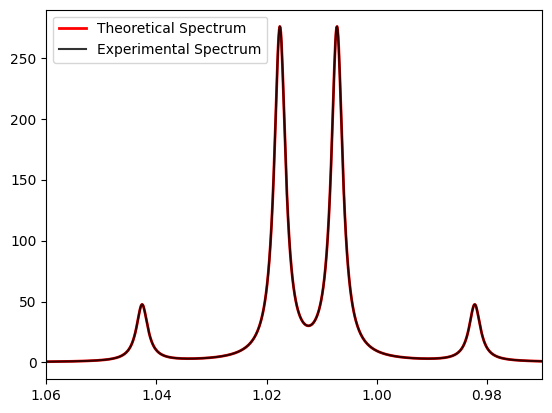

In [41]:
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[0][-1]*factor,UFE[0][-1], TFE[0],xlim=[1.06,0.97])

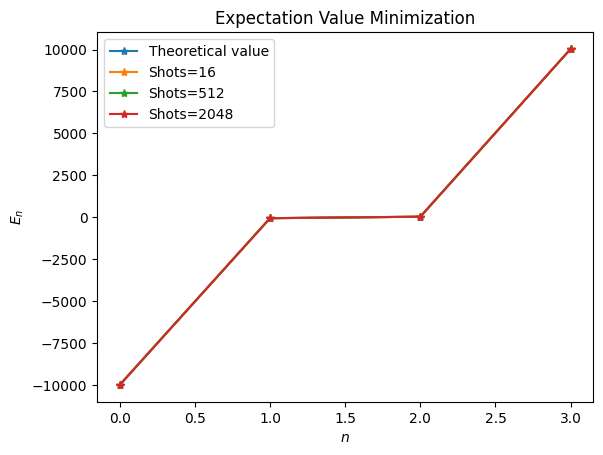

In [42]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

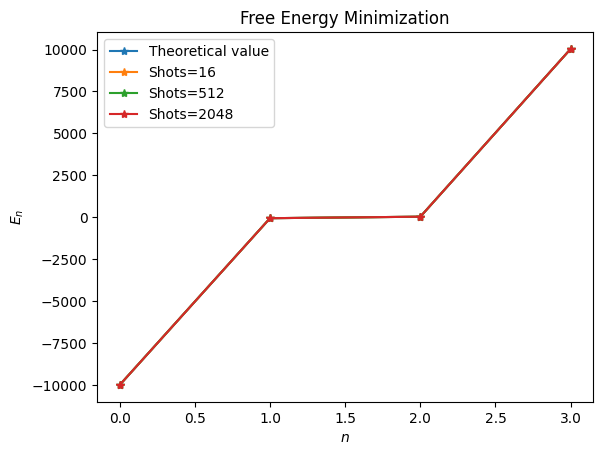

In [43]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Efreeenerg[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

### AX system

In [44]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))
shotslist=[2**4,2**9,2**11]

In [45]:
# Construimos H para el sistema AX.
offset=5
B=400
shifts=[1,1.2]
J=[4]
matrizAX=Hspin(shifts,J,offset,B)

In [46]:
results_expect=[]
energies_expect=[]
UExpect=[]
niterExpect=[]
tExpect=[]
TExp=[]
results_free_energy=[]
energies_free_energy=[]
UFE=[]
niterFE=[]
tFE=[]
TFE=[]
for shots in shotslist:
    results_expecti, energies_expecti, UExpecti, niterExpecti, tExpecti, TExpi=minimize_function(matrizAX,expectation_classic,betas,shots=shots)
    results_free_energyi, energies_free_energyi, UFEi, niterFEi, tFEi, TFEi=minimize_function(matrizAX,free_energy,betas,shots=shots)
    results_expect.append(results_expecti)
    energies_expect.append(energies_expecti)
    UExpect.append(UExpecti)
    niterExpect.append(niterExpecti)
    tExpect.append(tExpecti)
    TExp.append(TExpi)
    results_free_energy.append(results_free_energyi)
    energies_free_energy.append(energies_free_energyi)
    UFE.append(UFEi)
    niterFE.append(niterFEi)
    tFE.append(tFEi)
    TFE.append(TFEi)

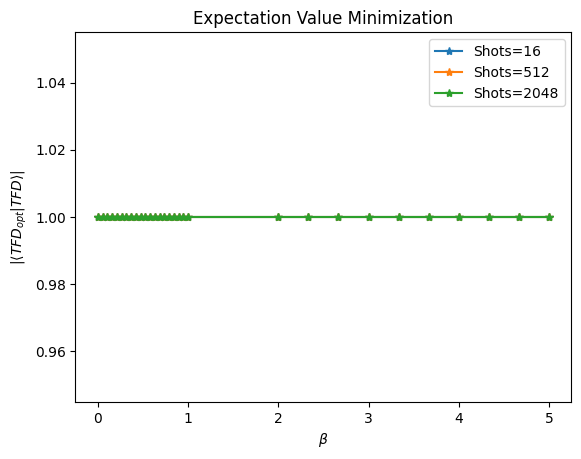

In [47]:
for i in range(len(shotslist)):
    plt.plot(betas, results_expect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

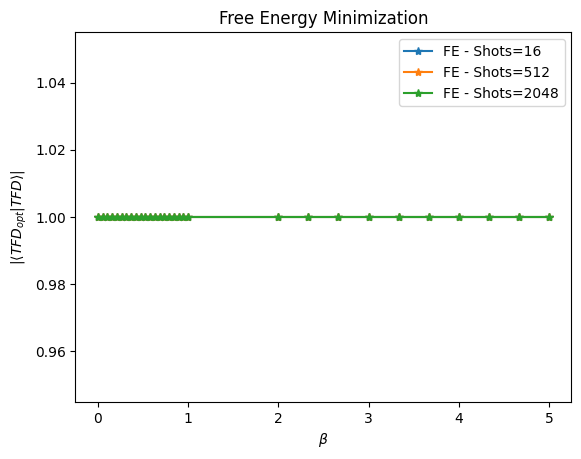

In [48]:
for i in range(len(shotslist)):
    plt.plot(betas, results_free_energy[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

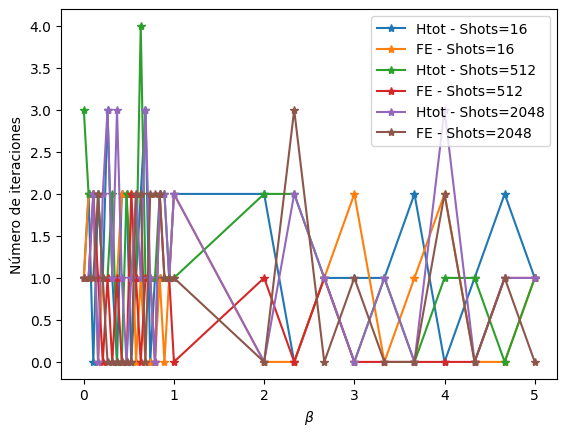

In [49]:
for i in range(len(shotslist)):
    plt.plot(betas, niterExpect[i], '*-', label='Htot - Shots='+str(shotslist[i]))
    plt.plot(betas, niterFE[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

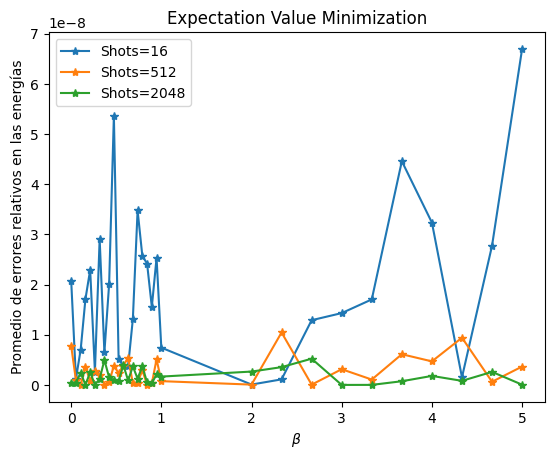

In [50]:
Eteo=np.sort(np.linalg.eig(matrizAX.to_matrix())[0])
Eexpect=[[np.sort(energies_expect[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
Efreeenerg=[[np.sort(energies_free_energy[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
relerrorExpect=[[1/(len(Eteo))*sum([abs((Eexpect[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
relerrorFE=[[1/(len(Eteo))*sum([abs((Efreeenerg[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
for i in range(len(shotslist)):
    plt.plot(betas, relerrorExpect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

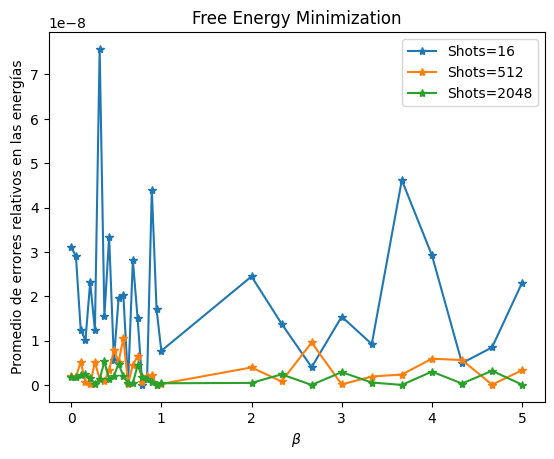

In [51]:
for i in range(len(shotslist)):
    plt.plot(betas, relerrorFE[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [52]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([[-9795.48589389,  -257.92456031,   245.35819014,  9808.0522642 ],
       [-9795.48589399,  -257.92456076,   245.35819045,  9808.05226923],
       [-9795.48589389,  -257.92456235,   245.35819101,  9808.05226451],
       [-9795.48589389,  -257.92456076,   245.35819014,  9808.05226536],
       [-9795.48589389,  -257.92455819,   245.35819014,  9808.05226357],
       [-9795.48589389,  -257.92456076,   245.35819014,  9808.05226593],
       [-9795.48589389,  -257.92456076,   245.35818901,  9808.05226273],
       [-9795.48589389,  -257.92456323,   245.35818798,  9808.05227804],
       [-9795.48589389,  -257.92456076,   245.35819146,  9808.05225875],
       [-9795.48589389,  -257.92455988,   245.35819014,  9808.05225993],
       [-9795.48589389,  -257.92456148,   245.35819007,  9808.05226568],
       [-9795.48589389,  -257.92455757,   245.35818932,  9808.05226451],
       [-9795.48589389,  -257.92455986,   245.35819014,  9808.0522657 ],
       [-9795.48589389,  -257.9245587 ,   245.35818

In [53]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([[-9795.48589389,  -257.92456076,   245.35818849,  9808.05226354],
       [-9795.48589389,  -257.92456252,   245.35819014,  9808.05226315],
       [-9795.48589389,  -257.92456238,   245.35819066,  9808.05227084],
       [-9795.48589389,  -257.92456332,   245.35819014,  9808.05226451],
       [-9795.48589389,  -257.92456198,   245.35819049,  9808.05226614],
       [-9795.48589622,  -257.92456076,   245.35819014,  9808.05225609],
       [-9795.48589389,  -257.92456076,   245.35818892,  9808.05226453],
       [-9795.48589389,  -257.92456395,   245.35818806,  9808.0522619 ],
       [-9795.48589389,  -257.92455943,   245.35819014,  9808.05226322],
       [-9795.48589389,  -257.92456271,   245.35819014,  9808.05225747],
       [-9795.48589389,  -257.92456242,   245.35819318,  9808.05226554],
       [-9795.48589389,  -257.92456076,   245.35819207,  9808.05226488],
       [-9795.48589389,  -257.92456097,   245.35819014,  9808.05225917],
       [-9795.48589389,  -257.9245611 ,   245.35819

In [54]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAX.to_matrix())[0])

array([-9795.48589389+0.j,  -257.92456076+0.j,   245.35819014+0.j,
        9808.05226451+0.j])

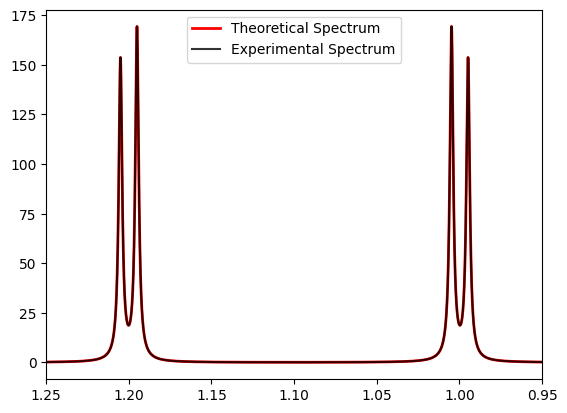

In [55]:
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[0][-1]*factor,UFE[0][-1], TFE[0],xlim=[1.25,0.95])

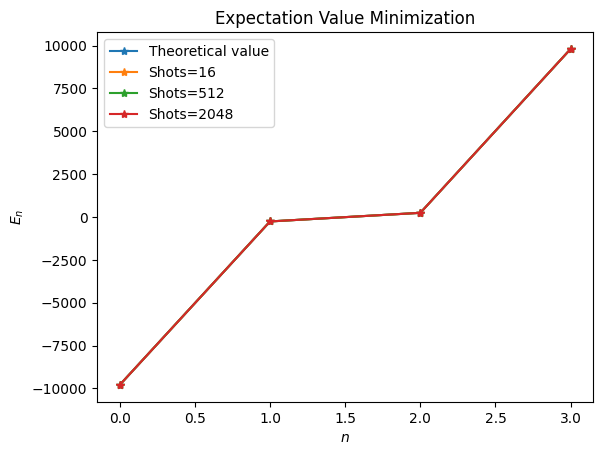

In [56]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

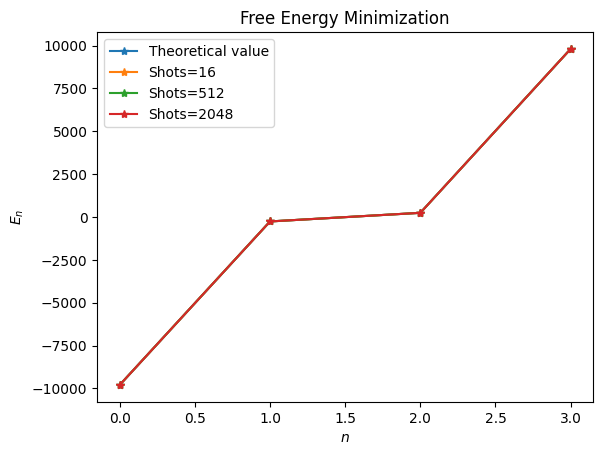

In [57]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Efreeenerg[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

### AMX system

In [26]:
betas = [0.5]
shotslist=[2048]

In [27]:
# Construimos H para el sistema AMX.
offset=5
B=400
shifts=[1,1.2,1.5]
J=[3,10,8]
matrizAMX=Hspin(shifts,J,offset,B)

In [28]:
results_expect=[]
energies_expect=[]
UExpect=[]
niterExpect=[]
tExpect=[]
TExp=[]
results_free_energy=[]
energies_free_energy=[]
UFE=[]
niterFE=[]
tFE=[]
TFE=[]
for shots in shotslist:
    #results_expecti, energies_expecti, UExpecti, niterExpecti, tExpecti, TExpi=minimize_function(matrizAMX,expectation_classic,betas,shots=shots)
    results_free_energyi, energies_free_energyi, UFEi, niterFEi, tFEi, TFEi=minimize_function(matrizAMX,free_energy,betas,shots=shots)
    results_expect.append(results_expecti)
    energies_expect.append(energies_expecti)
    UExpect.append(UExpecti)
    niterExpect.append(niterExpecti)
    tExpect.append(tExpecti)
    TExp.append(TExpi)
    results_free_energy.append(results_free_energyi)
    energies_free_energy.append(energies_free_energyi)
    UFE.append(UFEi)
    niterFE.append(niterFEi)
    tFE.append(tFEi)
    TFE.append(TFEi)

NameError: name 'results_expecti' is not defined

In [31]:
np.float64(job.result().values[0])

np.float64(14.232985511043925)

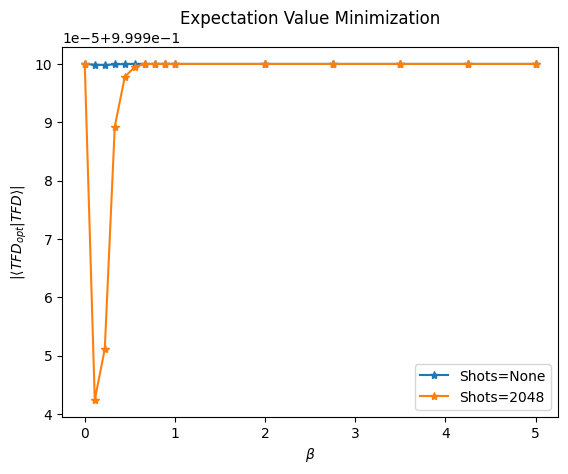

In [69]:
for i in range(len(shotslist)):
    plt.plot(betas, results_expect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

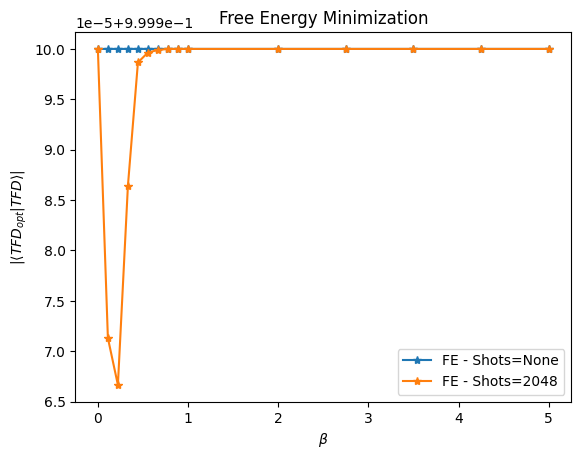

In [70]:
for i in range(len(shotslist)):
    plt.plot(betas, results_free_energy[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

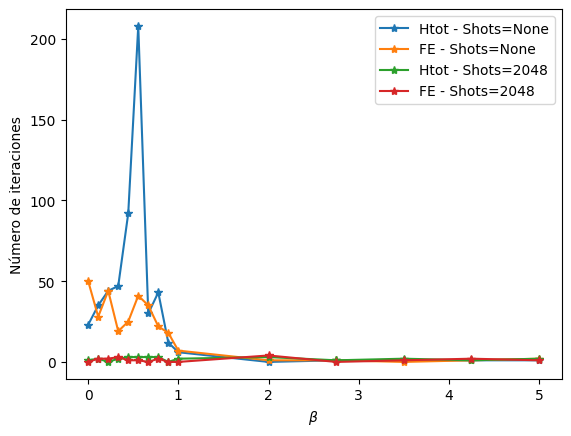

In [71]:
for i in range(len(shotslist)):
    plt.plot(betas, niterExpect[i], '*-', label='Htot - Shots='+str(shotslist[i]))
    plt.plot(betas, niterFE[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

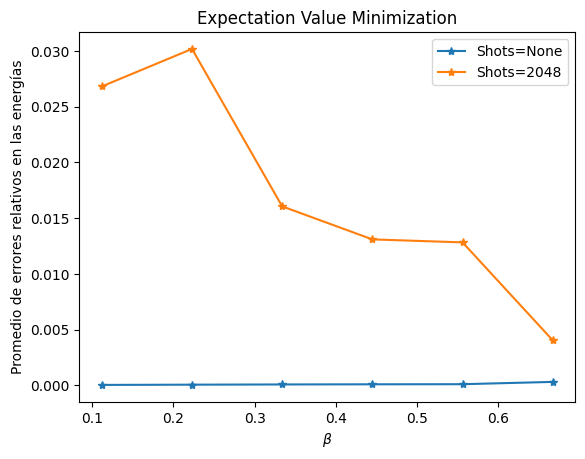

In [72]:
Eteo=np.sort(np.linalg.eig(matrizAMX.to_matrix())[0])
Eexpect=[[np.sort(energies_expect[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
Efreeenerg=[[np.sort(energies_free_energy[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
relerrorExpect=[[1/(len(Eteo))*sum([abs((Eexpect[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
relerrorFE=[[1/(len(Eteo))*sum([abs((Efreeenerg[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
for i in range(len(shotslist)):
    plt.plot(betas[1:7], relerrorExpect[i][1:7], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

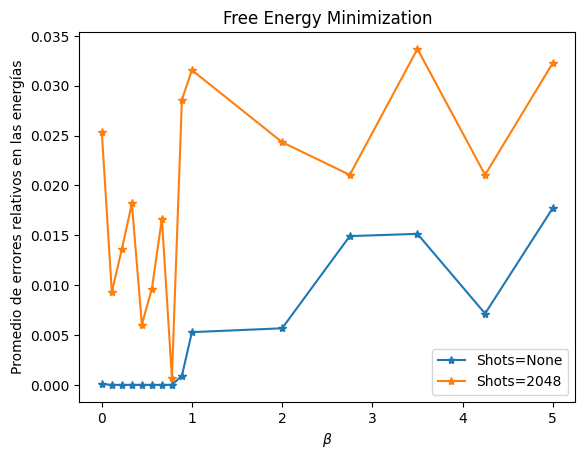

In [73]:
for i in range(len(shotslist)):
    plt.plot(betas, relerrorFE[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [74]:
betas

[np.float64(0.001),
 np.float64(0.112),
 np.float64(0.223),
 np.float64(0.334),
 np.float64(0.445),
 np.float64(0.556),
 np.float64(0.667),
 np.float64(0.778),
 np.float64(0.889),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(2.75),
 np.float64(3.5),
 np.float64(4.25),
 np.float64(5.0)]

In [75]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([[-14167.01207446,  -5428.67353603,  -4650.53387593,
         -4153.7781004 ,   4268.94954255,   4640.07753432,
          5256.98171263,  14232.98551709],
       [-14167.01206882,  -5428.67353834,  -4650.53387587,
         -4153.7780971 ,   4620.51678681,   4669.34243712,
          4880.63383926,  14232.98551709],
       [-14167.01206872,  -5428.67353684,  -4650.53387769,
         -4153.77810464,   4593.03871265,   4761.16082035,
          4806.37684561,  14232.98551163],
       [-14167.01207136,  -5428.67354583,  -4650.53387775,
         -4153.77809608,   4339.97107765,   4759.05655021,
          5082.70172845,  14232.98551709],
       [-14167.01207598,  -5428.6735416 ,  -4650.53387587,
         -4153.77810261,   4309.45057423,   4721.65462651,
          5127.15810428,  14232.98551709],
       [-14167.01207584,  -5428.67353165,  -4650.53387587,
         -4153.77811687,   4361.83353433,   4662.28943138,
          5138.10069809,  14232.98551715],
       [-14167.01206968,  -5428.67

In [76]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([[-14167.01207136,  -5428.67354134,  -4650.53387528,
         -4153.77809947,   4600.99120426,   4672.05658735,
          4922.32756203,  14232.98551709],
       [-14167.01207568,  -5428.67353841,  -4650.53387587,
         -4153.77810779,   4313.24538255,   4649.35271672,
          5211.37876868,  14232.98551709],
       [-14167.01207136,  -5428.67353824,  -4650.53387587,
         -4153.77810036,   4367.59679431,   4667.89906561,
          5117.45500214,  14232.98551709],
       [-14167.01207136,  -5428.67354219,  -4650.53387587,
         -4153.77810191,   4485.23173412,   4647.00919429,
          5049.94476751,  14232.98551709],
       [-14167.01207143,  -5428.67353922,  -4650.53387587,
         -4153.77810731,   4243.27126229,   4653.16036852,
          5264.40359465,  14232.98552707],
       [-14167.01207136,  -5428.67355083,  -4650.53387587,
         -4153.77810249,   4292.11737175,   4679.44360241,
          5203.48007811,  14232.98551709],
       [-14167.0120634 ,  -5428.67

In [77]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAMX.to_matrix())[0])

array([-14167.01207136+0.j,  -5428.67353922+0.j,  -4650.53387587+0.j,
        -4153.77810199+0.j,   4138.10193822+0.j,   4647.26099524+0.j,
         5381.6491379 +0.j,  14232.98551709+0.j])

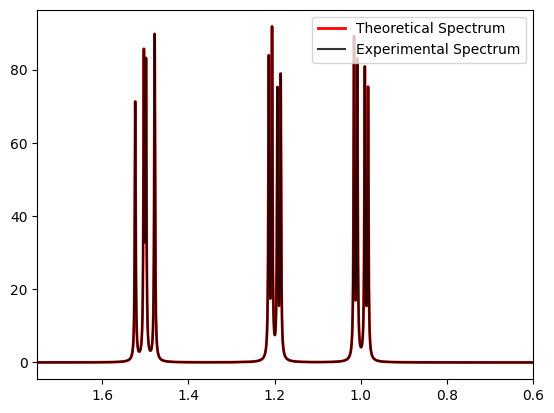

In [78]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[0][1]*factor,UFE[0][1], TFE[0],xlim=[1.75,0.6])

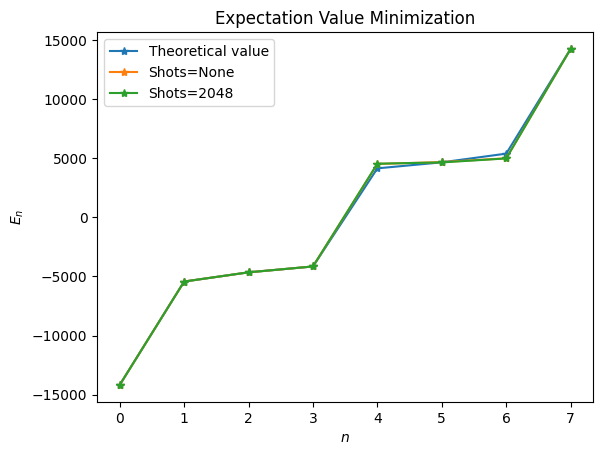

In [79]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

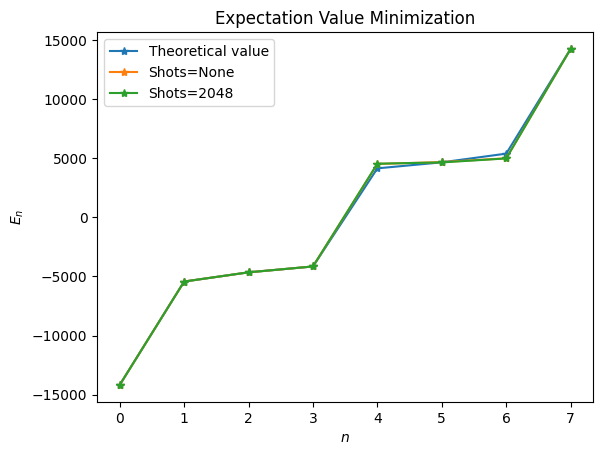

In [80]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

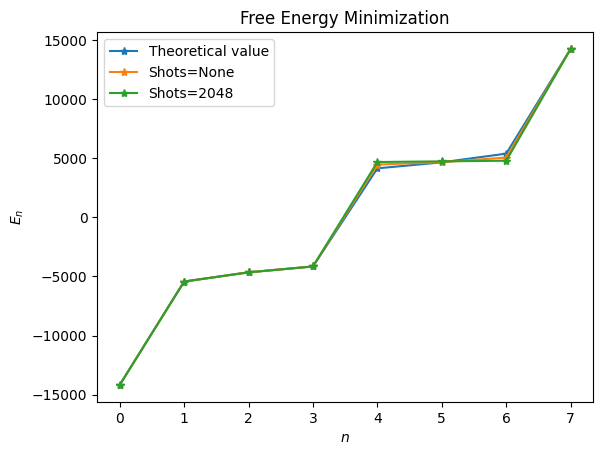

In [81]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Efreeenerg[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

### ABX system

In [73]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))
shotslist=[2**4,2**9,2**11]

In [74]:
# Construimos H para el sistema ABX.
offset=5
B=400
shifts=[1,1.025,1.5]
J=[10,6,4]
matrizABX=Hspin(shifts,J,offset,B)

In [75]:
results_expect=[]
energies_expect=[]
UExpect=[]
niterExpect=[]
tExpect=[]
TExp=[]
results_free_energy=[]
energies_free_energy=[]
UFE=[]
niterFE=[]
tFE=[]
TFE=[]
for shots in shotslist:
    results_expecti, energies_expecti, UExpecti, niterExpecti, tExpecti, TExpi=minimize_function(matrizABX,expectation_classic,betas,shots=shots)
    results_free_energyi, energies_free_energyi, UFEi, niterFEi, tFEi, TFEi=minimize_function(matrizABX,free_energy,betas,shots=shots)
    results_expect.append(results_expecti)
    energies_expect.append(energies_expecti)
    UExpect.append(UExpecti)
    niterExpect.append(niterExpecti)
    tExpect.append(tExpecti)
    TExp.append(TExpi)
    results_free_energy.append(results_free_energyi)
    energies_free_energy.append(energies_free_energyi)
    UFE.append(UFEi)
    niterFE.append(niterFEi)
    tFE.append(tFEi)
    TFE.append(TFEi)

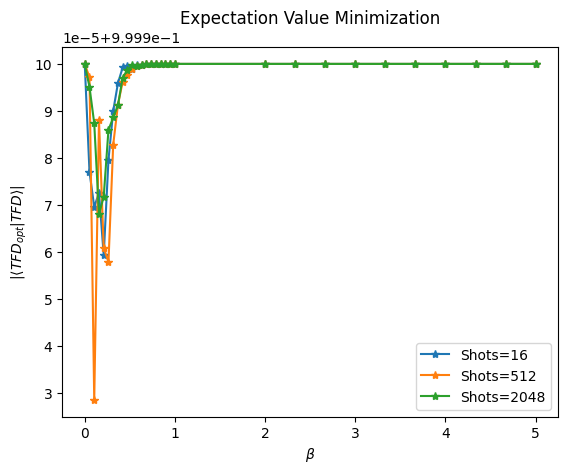

In [76]:
for i in range(len(shotslist)):
    plt.plot(betas, results_expect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

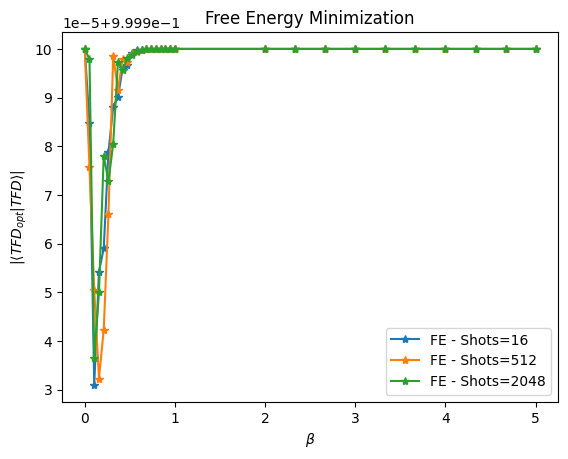

In [77]:
for i in range(len(shotslist)):
    plt.plot(betas, results_free_energy[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

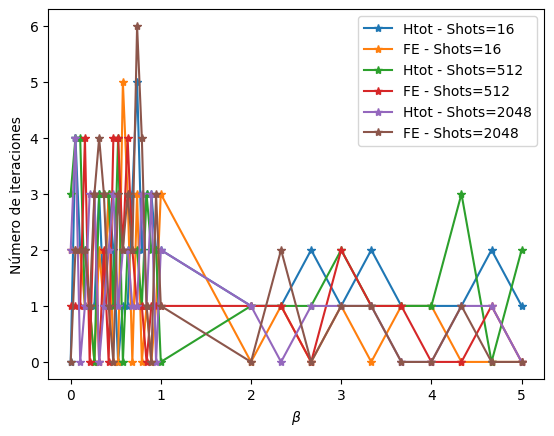

In [78]:
for i in range(len(shotslist)):
    plt.plot(betas, niterExpect[i], '*-', label='Htot - Shots='+str(shotslist[i]))
    plt.plot(betas, niterFE[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

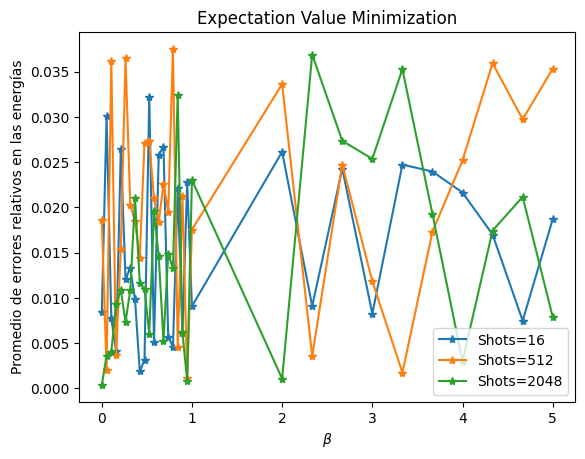

In [79]:
Eteo=np.sort(np.linalg.eig(matrizABX.to_matrix())[0])
Eexpect=[[np.sort(energies_expect[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
Efreeenerg=[[np.sort(energies_free_energy[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
relerrorExpect=[[1/(len(Eteo))*sum([abs((Eexpect[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
relerrorFE=[[1/(len(Eteo))*sum([abs((Efreeenerg[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
for i in range(len(shotslist)):
    plt.plot(betas, relerrorExpect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

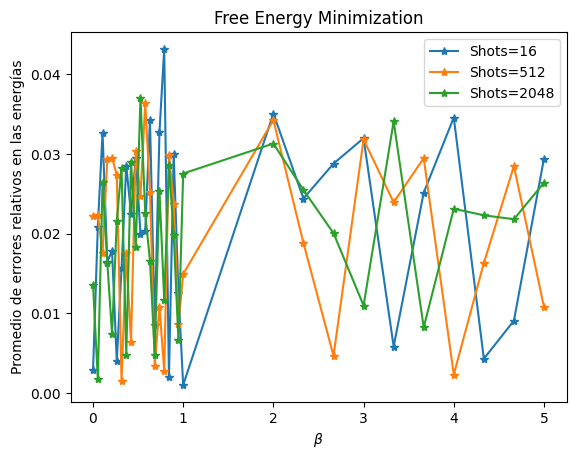

In [80]:
for i in range(len(shotslist)):
    plt.plot(betas, relerrorFE[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [81]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([[-14388.49435427,  -5623.86154703,  -4456.19110702,
         -4371.27355247,   4336.19045384,   4434.7938628 ,
          5614.7650693 ,  14451.32620651],
       [-14388.4943491 ,  -5623.86154703,  -4456.19110702,
         -4371.27355247,   4385.21155309,   4444.06913262,
          5544.15920925,  14451.32620651],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355273,   4340.38462147,   4509.74141435,
          5552.6691651 ,  14451.32620651],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355238,   4396.8582936 ,   4569.57629477,
          5462.23957332,  14451.32621036],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355247,   4478.27172561,   4504.93234235,
          5414.76757354,  14451.32620651],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355325,   4425.41532856,   4475.39705587,
          5469.19077394,  14451.32620587],
       [-14388.4943486 ,  -5623.86

In [82]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([[-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355261,   4368.51765494,   4663.02378576,
          5356.51618662,  14451.32620651],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355181,   4370.9080227 ,   4423.99055998,
          5597.97263868,  14451.32620651],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355131,   4616.97842921,   4661.24927151,
          5091.77251628,  14451.32620651],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355404,   4453.25155501,   4642.03648855,
          5310.59781852,  14451.32620651],
       [-14388.4943506 ,  -5623.86154703,  -4456.19110702,
         -4371.27355236,   4443.28040648,   4468.70975298,
          5480.57218271,  14451.32620651],
       [-14388.49435344,  -5623.86154703,  -4456.19110702,
         -4371.27355247,   4339.29761523,   4853.69107196,
          5196.47280904,  14451.32620442],
       [-14388.49435344,  -5623.86

In [83]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizABX.to_matrix())[0])

array([-14388.49435344+0.j,  -5623.86154703+0.j,  -4456.19110702+0.j,
        -4371.27355247+0.j,   4335.68599523+0.j,   4428.93824614+0.j,
         5623.87011207+0.j,  14451.32620651+0.j])

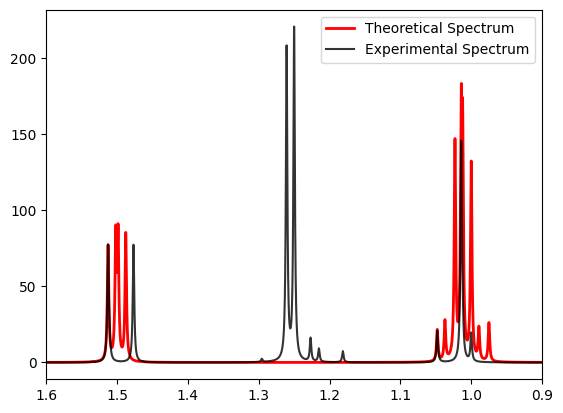

In [84]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[0][-1]*factor,UFE[0][-1],TFE[0],xlim=[1.6,0.9])

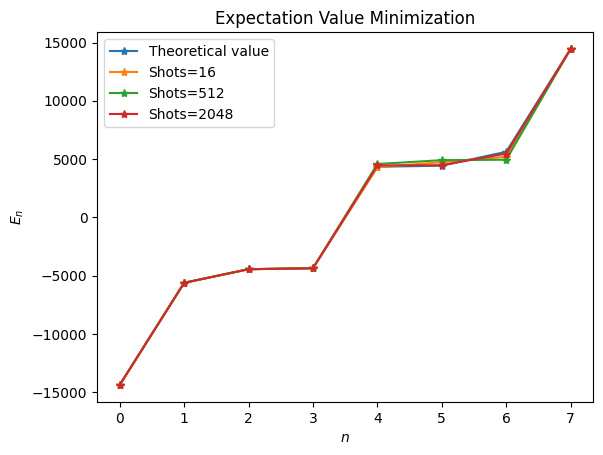

In [85]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

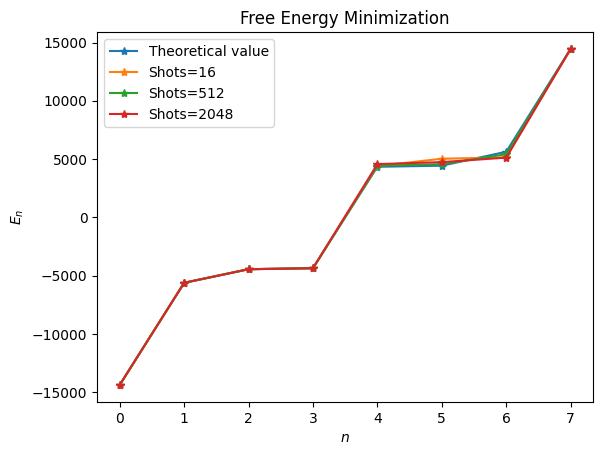

In [86]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Efreeenerg[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

### ABC system

In [87]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))
shotslist=[2**4,2**9,2**11]

In [88]:
# Construimos H para el sistema ABC.
offset=5
B=400
shifts=[1,1.025,1.05]
J=[8,10,8]
matrizABC=Hspin(shifts,J,offset,B)

In [89]:
results_expect=[]
energies_expect=[]
UExpect=[]
niterExpect=[]
tExpect=[]
TExp=[]
results_free_energy=[]
energies_free_energy=[]
UFE=[]
niterFE=[]
tFE=[]
TFE=[]
for shots in shotslist:
    results_expecti, energies_expecti, UExpecti, niterExpecti, tExpecti, TExpi=minimize_function(matrizABC,expectation_classic,betas,shots=shots)
    results_free_energyi, energies_free_energyi, UFEi, niterFEi, tFEi, TFEi=minimize_function(matrizABC,free_energy,betas,shots=shots)
    results_expect.append(results_expecti)
    energies_expect.append(energies_expecti)
    UExpect.append(UExpecti)
    niterExpect.append(niterExpecti)
    tExpect.append(tExpecti)
    TExp.append(TExpi)
    results_free_energy.append(results_free_energyi)
    energies_free_energy.append(energies_free_energyi)
    UFE.append(UFEi)
    niterFE.append(niterFEi)
    tFE.append(tFEi)
    TFE.append(TFEi)

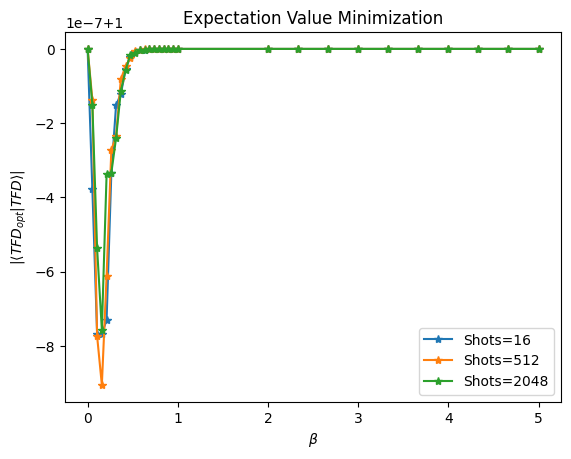

In [90]:
for i in range(len(shotslist)):
    plt.plot(betas, results_expect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

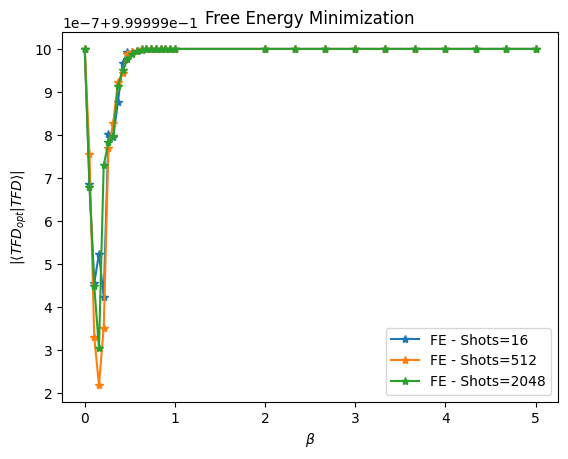

In [91]:
for i in range(len(shotslist)):
    plt.plot(betas, results_free_energy[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

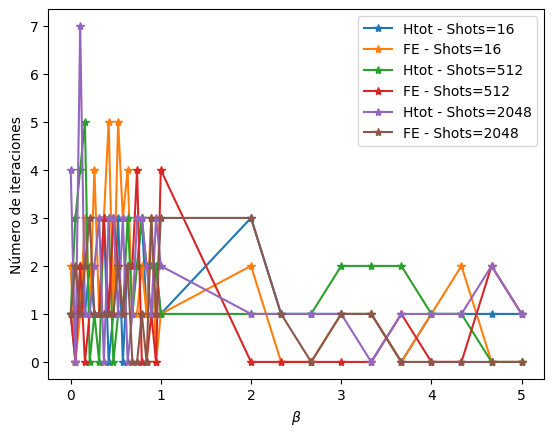

In [92]:
for i in range(len(shotslist)):
    plt.plot(betas, niterExpect[i], '*-', label='Htot - Shots='+str(shotslist[i]))
    plt.plot(betas, niterFE[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

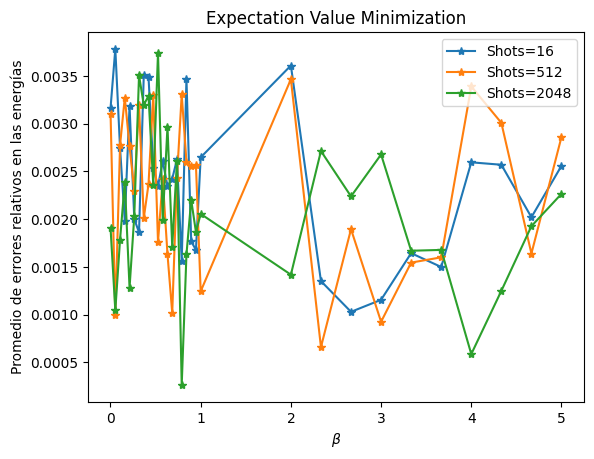

In [93]:
Eteo=np.sort(np.linalg.eig(matrizABC.to_matrix())[0])
Eexpect=[[np.sort(energies_expect[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
Efreeenerg=[[np.sort(energies_free_energy[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
relerrorExpect=[[1/(len(Eteo))*sum([abs((Eexpect[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
relerrorFE=[[1/(len(Eteo))*sum([abs((Efreeenerg[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
for i in range(len(shotslist)):
    plt.plot(betas, relerrorExpect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

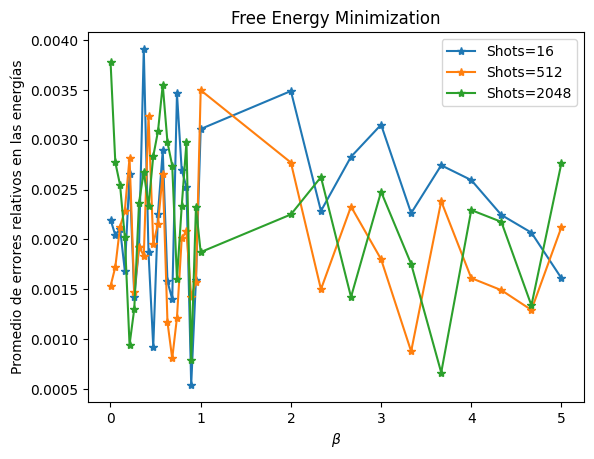

In [94]:
for i in range(len(shotslist)):
    plt.plot(betas, relerrorFE[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [95]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([[-14944.55625313,  -5085.75050922,  -5012.24343415,
         -4928.24372415,   4932.26069675,   4988.89931779,
          5024.62597894,  15026.23766175],
       [-14944.55625313,  -5085.75050382,  -5012.24342978,
         -4928.24372415,   4922.11494656,   4982.09234293,
          5042.05665853,  15026.23766889],
       [-14944.55626187,  -5085.75050859,  -5012.24343415,
         -4928.24372415,   4931.71063497,   4987.08063554,
          5026.98817088,  15026.23766212],
       [-14944.55625313,  -5085.75049976,  -5012.24343813,
         -4928.24372415,   4952.07246517,   4971.43786662,
          5020.94522622,  15026.23766212],
       [-14944.55625313,  -5085.75050303,  -5012.24343838,
         -4928.24372415,   4927.90697254,   4969.67665964,
          5042.79284779,  15026.2376596 ],
       [-14944.55625313,  -5085.75050718,  -5012.24343664,
         -4928.24372415,   4939.55212737,   4983.97677046,
          5021.91254425,  15026.23766517],
       [-14944.55625313,  -5085.75

In [96]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([[-14944.55625313,  -5085.7505069 ,  -5012.24343078,
         -4928.24372415,   4977.35598127,   4981.00276434,
          4987.287691  ,  15026.23766212],
       [-14944.55625313,  -5085.75050193,  -5012.24343415,
         -4928.24372415,   4942.40989799,   4994.60935974,
          5005.7080889 ,  15026.23766212],
       [-14944.55625313,  -5085.75050697,  -5012.24343692,
         -4928.24372415,   4926.42586585,   5006.72708855,
          5010.73884058,  15026.23766212],
       [-14944.55625313,  -5085.75050976,  -5012.24343072,
         -4928.24372415,   4939.75026665,   4982.97171413,
          5021.49424452,  15026.2376741 ],
       [-14944.55625313,  -5085.75050458,  -5012.24343223,
         -4928.24372415,   4917.50752912,   4985.20776439,
          5044.47621054,  15026.23766282],
       [-14944.55625313,  -5085.75050075,  -5012.24343365,
         -4928.24372415,   4923.15364312,   4987.03570897,
          5037.58051495,  15026.23766212],
       [-14944.55627897,  -5085.75

In [97]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizABC.to_matrix())[0])

array([-14944.55625313+0.j,  -5085.75050383+0.j,  -5012.24343415+0.j,
        -4928.24372415+0.j,   4904.51413459+0.j,   4978.02120427+0.j,
         5062.02091427+0.j,  15026.23766212+0.j])

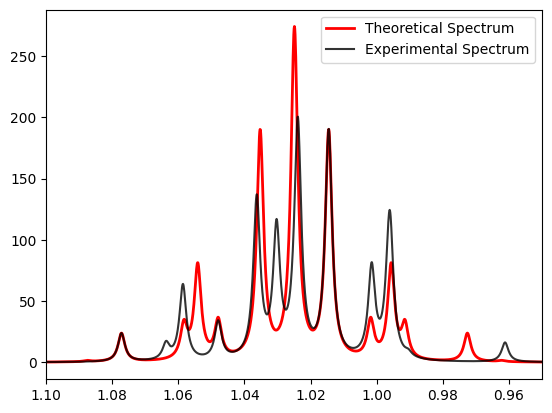

In [98]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[0][-1]*factor,UFE[0][-1],TFE[0],xlim=[1.1,0.95])

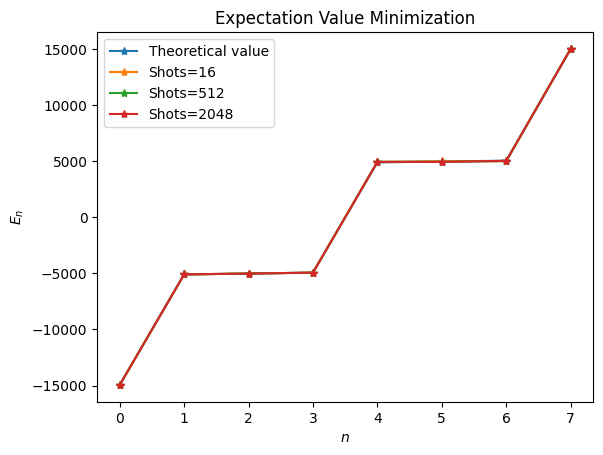

In [99]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

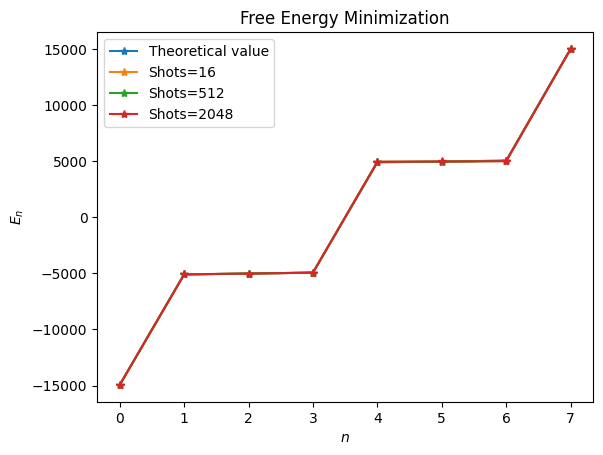

In [100]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Efreeenerg[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

### AMPX system

In [ ]:
betas = list(np.linspace(0.001,1,6))+list(np.linspace(2,5,4))

In [ ]:
# Construimos H para el sistema AMPX.
offset=0
B=400
shifts=[1,1.3,2,2.5]
J=[10,7,2,15,9,20]
matrizAMPX=Hspin(shifts,J,offset,B)

In [ ]:
results_expect=[]
energies_expect=[]
UExpect=[]
niterExpect=[]
tExpect=[]
TExp=[]
results_free_energy=[]
energies_free_energy=[]
UFE=[]
niterFE=[]
tFE=[]
TFE=[]
for shots in shotslist:
    results_expecti, energies_expecti, UExpecti, niterExpecti, tExpecti, TExpi=minimize_function(matrizAMPX,expectation_classic,betas,shots=shots)
    results_free_energyi, energies_free_energyi, UFEi, niterFEi, tFEi, TFEi=minimize_function(matrizAMPX,free_energy,betas,shots=shots)
    results_expect.append(results_expecti)
    energies_expect.append(energies_expecti)
    UExpect.append(UExpecti)
    niterExpect.append(niterExpecti)
    tExpect.append(tExpecti)
    TExp.append(TExpi)
    results_free_energy.append(results_free_energyi)
    energies_free_energy.append(energies_free_energyi)
    UFE.append(UFEi)
    niterFE.append(niterFEi)
    tFE.append(tFEi)
    TFE.append(TFEi)

In [ ]:
for i in range(len(shotslist)):
    plt.plot(betas, results_expect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

In [ ]:
for i in range(len(shotslist)):
    plt.plot(betas, results_free_energy[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [ ]:
for i in range(len(shotslist)):
    plt.plot(betas, niterExpect[i], '*-', label='Htot - Shots='+str(shotslist[i]))
    plt.plot(betas, niterFE[i], '*-', label='FE - Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [ ]:
Eteo=np.sort(np.linalg.eig(matrizAMPX.to_matrix())[0])
Eexpect=[[np.sort(energies_expect[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
Efreeenerg=[[np.sort(energies_free_energy[j][i])*factor for i in range(len(betas))] for j in range(len(shotslist))]
relerrorExpect=[[1/(len(Eteo))*sum([abs((Eexpect[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
relerrorFE=[[1/(len(Eteo))*sum([abs((Efreeenerg[k][i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))] for k in range(len(shotslist))]
for i in range(len(shotslist)):
    plt.plot(betas, relerrorExpect[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

In [ ]:
for i in range(len(shotslist)):
    plt.plot(betas, relerrorFE[i], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

In [ ]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAMPX.to_matrix())[0])

In [ ]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[0][-1]*factor,UFE[0][-1],TFE[0],xlim=[3.5,0])

In [ ]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Eexpect[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Expectation Value Minimization')
plt.legend()
plt.show()

In [ ]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
for i in range(len(shotslist)):
    plt.plot(range(n), Efreeenerg[i][-1], '*-', label='Shots='+str(shotslist[i]))
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.title('Free Energy Minimization')
plt.legend()
plt.show()